In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [90]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [92]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]


Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [93]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [94]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [95]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()

class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)
    

pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
# focal_loss(pred, target)
multi_scale_pooling_loss(pred, target)

tensor(1477.1957)

Training epoch 0


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=1.01e+3]


- Log loss: 1050.2939453125
- mIoU: 0.0015461521688848734
Training epoch 1


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=897]    


- Log loss: 904.6004638671875
- mIoU: 1.7280088818183437e-11
Training epoch 2


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=768]


- Log loss: 819.8966674804688
- mIoU: 1.0789832231239416e-05
Training epoch 3


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=718]


- Log loss: 767.5699462890625
- mIoU: 1.6772701283418456e-11
Training epoch 4


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=666]


- Log loss: 746.10546875
- mIoU: 1.9567561113098542e-11
Training epoch 5


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=606]


- Log loss: 703.1383666992188
- mIoU: 2.2632802938460372e-06
Training epoch 6


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=699]


- Log loss: 668.6228637695312
- mIoU: 2.018975091278019e-11
Training epoch 7


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=609]


- Log loss: 643.0659790039062
- mIoU: 1.8778352137149845e-11
Training epoch 8


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=563]


- Log loss: 587.09033203125
- mIoU: 1.8611830826520404e-11
Training epoch 9


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=544]


- Log loss: 524.7479248046875
- mIoU: 1.9051722005558602e-11
Training epoch 10


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=493]


- Log loss: 506.5709228515625
- mIoU: 0.0016447774833068252
Training epoch 11


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=437]


- Log loss: 485.3243408203125
- mIoU: 8.72331020218553e-06
Training epoch 12


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=447]


- Log loss: 510.9272766113281
- mIoU: 0.0029316991567611694
Training epoch 13


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=357]


- Log loss: 442.7485656738281
- mIoU: 0.0027831606566905975
Training epoch 14


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=463]


- Log loss: 430.0987854003906
- mIoU: 0.0020163850858807564
Training epoch 15


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=348]


- Log loss: 409.59979248046875
- mIoU: 0.013379452750086784
Training epoch 16


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=507]


- Log loss: 384.7056884765625
- mIoU: 0.006144853308796883
Training epoch 17


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=338]


- Log loss: 368.15069580078125
- mIoU: 0.004166426602751017
Training epoch 18


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=267]


- Log loss: 437.2154541015625
- mIoU: 0.026604047045111656
Training epoch 19


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=341]


- Log loss: 374.91217041015625
- mIoU: 0.007407147437334061


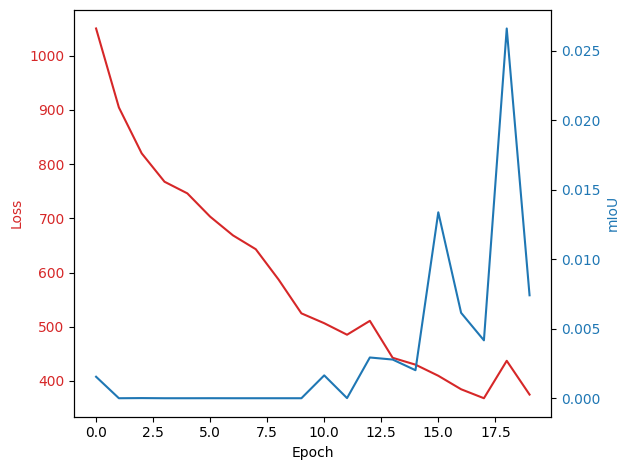

Training epoch 20


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=359]


- Log loss: 355.5730895996094
- mIoU: 0.009600328281521797
Training epoch 21


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=342]


- Log loss: 341.2704772949219
- mIoU: 0.02333298698067665
Training epoch 22


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=319]


- Log loss: 328.4230041503906
- mIoU: 0.009931794367730618
Training epoch 23


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=282]


- Log loss: 328.9560546875
- mIoU: 0.02487017773091793
Training epoch 24


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=365]


- Log loss: 333.8526916503906
- mIoU: 0.02265739068388939
Training epoch 25


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=262]


- Log loss: 326.3207092285156
- mIoU: 0.008810306899249554
Training epoch 26


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=380]


- Log loss: 304.0994873046875
- mIoU: 0.019652295857667923
Training epoch 27


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=171]


- Log loss: 279.63189697265625
- mIoU: 0.018313074484467506
Training epoch 33


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=278]


- Log loss: 291.3706970214844
- mIoU: 0.027620146051049232
Training epoch 34


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=237]


- Log loss: 278.803466796875
- mIoU: 0.017429586499929428
Training epoch 35


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=233]


- Log loss: 272.80279541015625
- mIoU: 0.028761720284819603
Training epoch 36


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=203]


- Log loss: 281.9317626953125
- mIoU: 0.02520187571644783
Training epoch 37


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=285]


- Log loss: 255.725341796875
- mIoU: 0.03069326840341091
Training epoch 38


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=239]


- Log loss: 270.28179931640625
- mIoU: 0.02443358488380909
Training epoch 39


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=205]


- Log loss: 273.4103698730469
- mIoU: 0.03114239126443863


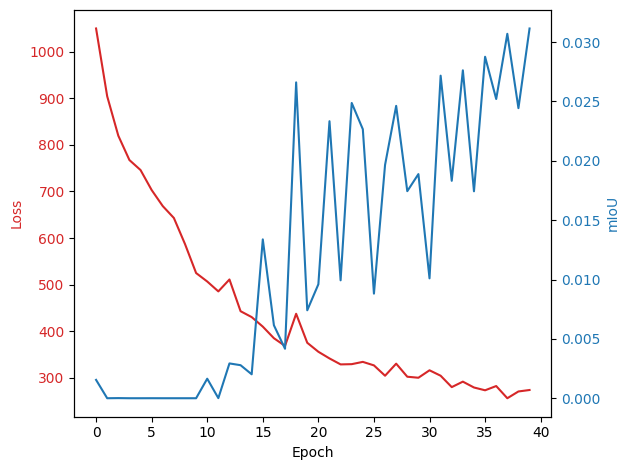

Training epoch 40


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=182]


- Log loss: 250.5921630859375
- mIoU: 0.02874414622783661
Training epoch 41


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=265]


- Log loss: 269.0732116699219
- mIoU: 0.028891300782561302
Training epoch 42


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=203]


- Log loss: 256.681396484375
- mIoU: 0.025060033425688744
Training epoch 43


100%|██████████| 75/75 [00:20<00:00,  3.57batch/s, loss=209]


- Log loss: 243.63682556152344
- mIoU: 0.029911473393440247
Training epoch 44


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=251]


- Log loss: 258.47247314453125
- mIoU: 0.031706590205430984
Training epoch 45


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=148]


- Log loss: 280.4881591796875
- mIoU: 0.020346343517303467
Training epoch 46


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=161]


- Log loss: 230.5663299560547
- mIoU: 0.03425365313887596
Training epoch 47


100%|██████████| 75/75 [00:24<00:00,  3.02batch/s, loss=330]


- Log loss: 240.67025756835938
- mIoU: 0.02775694988667965
Training epoch 48


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=153]


- Log loss: 250.91871643066406
- mIoU: 0.028836427256464958
Training epoch 49


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=166]


- Log loss: 220.66844177246094
- mIoU: 0.03356708213686943
Training epoch 50


100%|██████████| 75/75 [00:20<00:00,  3.58batch/s, loss=171]


- Log loss: 234.95655822753906
- mIoU: 0.034690067172050476
Training epoch 51


 59%|█████▊    | 44/75 [00:12<00:08,  3.58batch/s, loss=100]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



- Log loss: 225.28372192382812
- mIoU: 0.038013849407434464
Training epoch 53


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=182]


- Log loss: 275.8875732421875
- mIoU: 0.023198768496513367
Training epoch 54


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=148]


- Log loss: 273.01373291015625
- mIoU: 0.019166458398103714
Training epoch 55


100%|██████████| 75/75 [00:22<00:00,  3.39batch/s, loss=182]


- Log loss: 246.20106506347656
- mIoU: 0.029915237799286842
Training epoch 57


100%|██████████| 75/75 [00:22<00:00,  3.39batch/s, loss=124] 


- Log loss: 230.2657928466797
- mIoU: 0.02818909101188183
Epoch 00058: reducing learning rate of group 0 to 5.0000e-05.
Training epoch 58


100%|██████████| 75/75 [00:24<00:00,  3.09batch/s, loss=185] 


- Log loss: 222.3941192626953
- mIoU: 0.036850959062576294
Training epoch 59


100%|██████████| 75/75 [00:22<00:00,  3.37batch/s, loss=220] 


- Log loss: 206.2631378173828
- mIoU: 0.039501771330833435


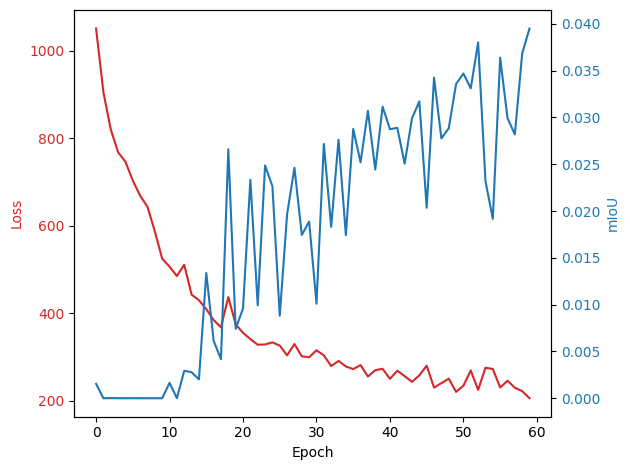

Training epoch 60


100%|██████████| 75/75 [00:21<00:00,  3.41batch/s, loss=253]


- Log loss: 212.82286071777344
- mIoU: 0.037535205483436584
Training epoch 61


100%|██████████| 75/75 [00:22<00:00,  3.33batch/s, loss=157] 


- Log loss: 219.8554229736328
- mIoU: 0.03965397924184799
Training epoch 62


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=222] 


- Log loss: 220.37655639648438
- mIoU: 0.035522401332855225
Training epoch 63


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=95.1]


- Log loss: 215.2418670654297
- mIoU: 0.03698374330997467
Training epoch 64


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=106] 


- Log loss: 211.25262451171875
- mIoU: 0.039934463798999786
Training epoch 65


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=211] 


- Log loss: 208.94187927246094
- mIoU: 0.039431389421224594
Training epoch 66


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=316] 


- Log loss: 199.90768432617188
- mIoU: 0.041034918278455734
Training epoch 67


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=208] 


- Log loss: 212.8523712158203
- mIoU: 0.03595074638724327
Training epoch 68


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=123] 


- Log loss: 201.97476196289062
- mIoU: 0.04064851999282837
Training epoch 69


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=290] 


- Log loss: 207.74465942382812
- mIoU: 0.0375322550535202
Training epoch 70


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=180]


- Log loss: 208.19476318359375
- mIoU: 0.039792500436306
Training epoch 71


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=200] 


- Log loss: 200.10836791992188
- mIoU: 0.03942050412297249
Training epoch 72


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=82]  


- Log loss: 215.28414916992188
- mIoU: 0.03879428282380104
Training epoch 73


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=234] 


- Log loss: 207.96788024902344
- mIoU: 0.03897949680685997
Training epoch 74


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=201] 


- Log loss: 254.57452392578125
- mIoU: 0.027269234880805016
Epoch 00075: reducing learning rate of group 0 to 2.5000e-05.
Training epoch 75


100%|██████████| 75/75 [00:24<00:00,  3.12batch/s, loss=179] 


- Log loss: 185.412353515625
- mIoU: 0.043748464435338974
Training epoch 79


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=136] 


- Log loss: 186.02227783203125
- mIoU: 0.04073098301887512


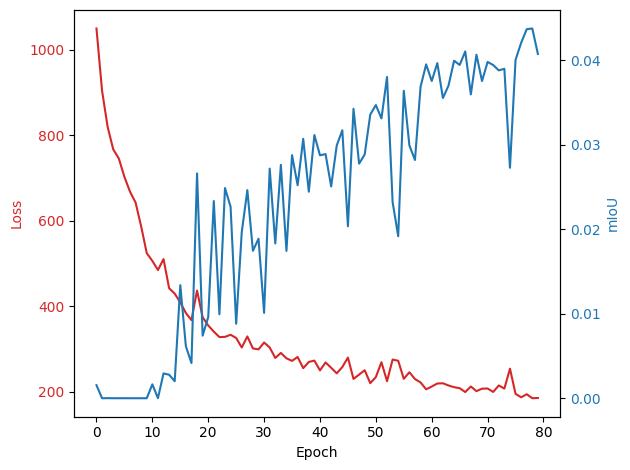

Training epoch 80


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=192] 


- Log loss: 186.447021484375
- mIoU: 0.0429578572511673
Training epoch 81


100%|██████████| 75/75 [00:20<00:00,  3.58batch/s, loss=109] 


- Log loss: 186.6246337890625
- mIoU: 0.04265899583697319
Training epoch 82


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=242] 


- Log loss: 186.245361328125
- mIoU: 0.044434476643800735
Training epoch 83


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=190] 


- Log loss: 182.64088439941406
- mIoU: 0.04431350901722908
Training epoch 84


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=184] 


- Log loss: 187.39739990234375
- mIoU: 0.04410618171095848
Training epoch 85


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=178] 


- Log loss: 181.40719604492188
- mIoU: 0.042236968874931335
Training epoch 86


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=130] 


- Log loss: 180.1753692626953
- mIoU: 0.04289429634809494
Training epoch 87


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=157] 


- Log loss: 182.7527313232422
- mIoU: 0.041343361139297485
Training epoch 88


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=239] 


- Log loss: 193.15164184570312
- mIoU: 0.04243672266602516
Training epoch 89


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=149] 


- Log loss: 188.7394561767578
- mIoU: 0.04423338547348976
Training epoch 90


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=96.5]


- Log loss: 182.2083282470703
- mIoU: 0.0417921282351017
Training epoch 91


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=182] 


- Log loss: 177.932861328125
- mIoU: 0.04450416564941406
Training epoch 92


100%|██████████| 75/75 [00:20<00:00,  3.71batch/s, loss=116] 


- Log loss: 177.8972625732422
- mIoU: 0.043928682804107666
Training epoch 93


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=98.2]


- Log loss: 188.97218322753906
- mIoU: 0.041664231568574905
Training epoch 94


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=164] 


- Log loss: 179.99000549316406
- mIoU: 0.041343096643686295
Training epoch 95


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=86.8]


- Log loss: 172.8666229248047
- mIoU: 0.045554596930742264
Training epoch 96


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=168] 


- Log loss: 178.80718994140625
- mIoU: 0.041087619960308075
Training epoch 97


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=166] 


- Log loss: 185.9987335205078
- mIoU: 0.042796168476343155
Training epoch 98


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=124] 


- Log loss: 177.89996337890625
- mIoU: 0.043707408010959625
Training epoch 99


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=116] 


- Log loss: 181.14666748046875
- mIoU: 0.04338490217924118


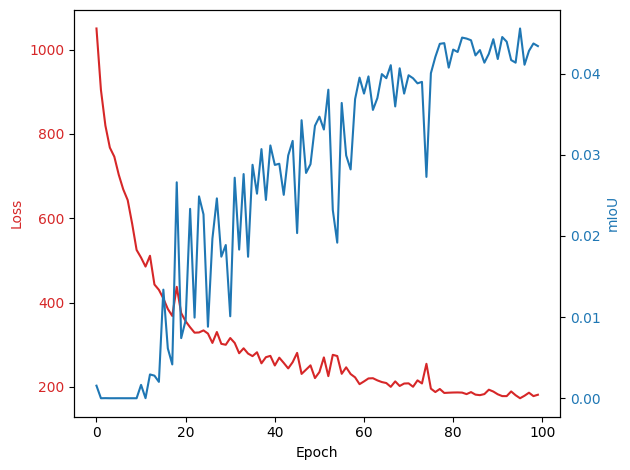

Training epoch 100


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=211] 


- Log loss: 177.3544921875
- mIoU: 0.04154278710484505
Training epoch 101


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=89.2]


- Log loss: 169.75416564941406
- mIoU: 0.04282614216208458
Training epoch 102


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=131] 


- Log loss: 181.42120361328125
- mIoU: 0.03980500251054764
Training epoch 103


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=155] 


- Log loss: 183.74241638183594
- mIoU: 0.04151902720332146
Training epoch 104


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=163] 


- Log loss: 188.7590789794922
- mIoU: 0.04202716052532196
Training epoch 105


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=149] 


- Log loss: 182.85887145996094
- mIoU: 0.042986419051885605
Training epoch 106


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=90]  


- Log loss: 180.4851531982422
- mIoU: 0.04459566995501518
Training epoch 107


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=83.4]


- Log loss: 181.55287170410156
- mIoU: 0.044129014015197754
Training epoch 108


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=141] 


- Log loss: 176.29458618164062
- mIoU: 0.04411567747592926
Training epoch 109


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=86.2]


- Log loss: 179.07423400878906
- mIoU: 0.04294418543577194
Epoch 00110: reducing learning rate of group 0 to 1.2500e-05.
Training epoch 110


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=120] 


- Log loss: 176.1265869140625
- mIoU: 0.04380699619650841
Training epoch 111


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=137] 


- Log loss: 181.44927978515625
- mIoU: 0.043931882828474045
Training epoch 112


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=85.8]


- Log loss: 177.18470764160156
- mIoU: 0.04354768991470337
Training epoch 113


100%|██████████| 75/75 [00:20<00:00,  3.58batch/s, loss=103] 


- Log loss: 181.4105987548828
- mIoU: 0.04369159787893295
Training epoch 114


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=136] 


- Log loss: 185.69500732421875
- mIoU: 0.04217603802680969
Training epoch 115


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=57.7]


- Log loss: 179.26612854003906
- mIoU: 0.04346355050802231
Training epoch 116


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=165] 


- Log loss: 179.43682861328125
- mIoU: 0.04422885179519653
Training epoch 117


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=114] 


- Log loss: 178.62974548339844
- mIoU: 0.043447934091091156
Epoch 00118: reducing learning rate of group 0 to 6.2500e-06.
Training epoch 118


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=86.5]


- Log loss: 175.25863647460938
- mIoU: 0.042920686304569244
Training epoch 119


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=78.6]


- Log loss: 179.61366271972656
- mIoU: 0.04251820966601372


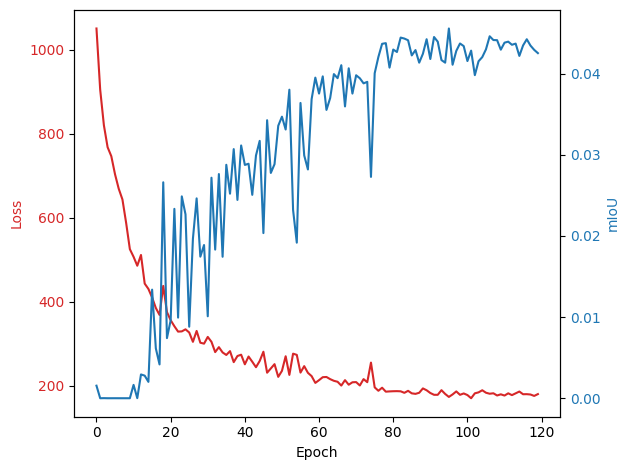

Training epoch 120


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=81.8]


- Log loss: 173.64862060546875
- mIoU: 0.04201345145702362
Training epoch 121


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=129] 


- Log loss: 176.03060913085938
- mIoU: 0.044199228286743164
Training epoch 122


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=85.8]


- Log loss: 171.7993621826172
- mIoU: 0.046347085386514664
Training epoch 123


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=115] 


- Log loss: 177.1959228515625
- mIoU: 0.04427842050790787
Training epoch 124


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=42.6]


- Log loss: 172.39028930664062
- mIoU: 0.042029302567243576
Training epoch 125


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=95.3]


- Log loss: 169.27273559570312
- mIoU: 0.04317500442266464
Training epoch 126


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=93.7]


- Log loss: 171.9051971435547
- mIoU: 0.04344668611884117
Training epoch 127


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=63.3]


- Log loss: 178.0174102783203
- mIoU: 0.04548133537173271
Training epoch 128


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=122] 


- Log loss: 174.19552612304688
- mIoU: 0.04519416764378548
Training epoch 129


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=130] 


- Log loss: 170.2010955810547
- mIoU: 0.044327691197395325
Training epoch 130


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=109] 


- Log loss: 172.09991455078125
- mIoU: 0.04532014951109886
Training epoch 131


100%|██████████| 75/75 [00:21<00:00,  3.54batch/s, loss=102] 


- Log loss: 176.8915557861328
- mIoU: 0.0440230555832386
Training epoch 132


100%|██████████| 75/75 [00:21<00:00,  3.57batch/s, loss=150] 


- Log loss: 183.37269592285156
- mIoU: 0.04555298760533333
Training epoch 133


100%|██████████| 75/75 [00:21<00:00,  3.54batch/s, loss=118] 


- Log loss: 177.24594116210938
- mIoU: 0.04601146653294563
Epoch 00134: reducing learning rate of group 0 to 3.1250e-06.
Training epoch 134


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=86.8]


- Log loss: 173.84962463378906
- mIoU: 0.04465873911976814
Training epoch 135


100%|██████████| 75/75 [00:21<00:00,  3.55batch/s, loss=70]  


- Log loss: 174.338623046875
- mIoU: 0.045179333537817
Training epoch 136


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=83.2]


- Log loss: 173.8832244873047
- mIoU: 0.04413243755698204
Training epoch 137


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=115] 


- Log loss: 171.42762756347656
- mIoU: 0.044081125408411026
Training epoch 138


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=375] 


- Log loss: 175.513671875
- mIoU: 0.045969780534505844
Training epoch 139


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=60.1]


- Log loss: 173.46197509765625
- mIoU: 0.043894294649362564


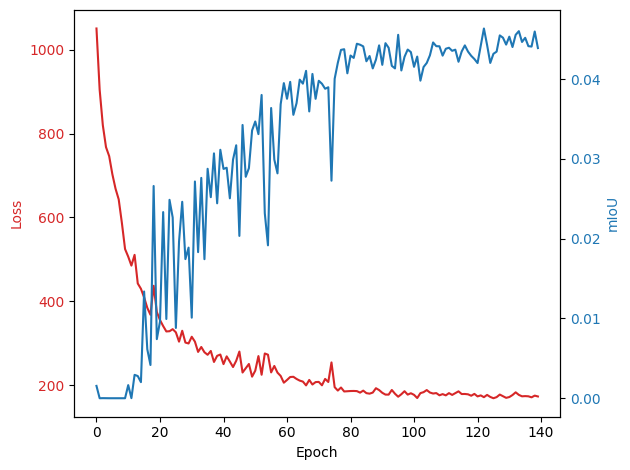

Training epoch 140


 24%|██▍       | 18/75 [00:04<00:15,  3.63batch/s, loss=121] 


KeyboardInterrupt: 

In [96]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=200)

In [ ]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [97]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [98]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  125



In [99]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [100]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out), np.squeeze(batch["target"]))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:26<00:00,  9.26it/s]

Mean Loss: 250.0345
Mean IoU: 0.5719
Mean Accuracy: 0.9837
Mean Recall: 0.7277
Mean False Positive Rate: 0.0067
Mean False Negative Rate: 0.7864


pos
29.40379413359919


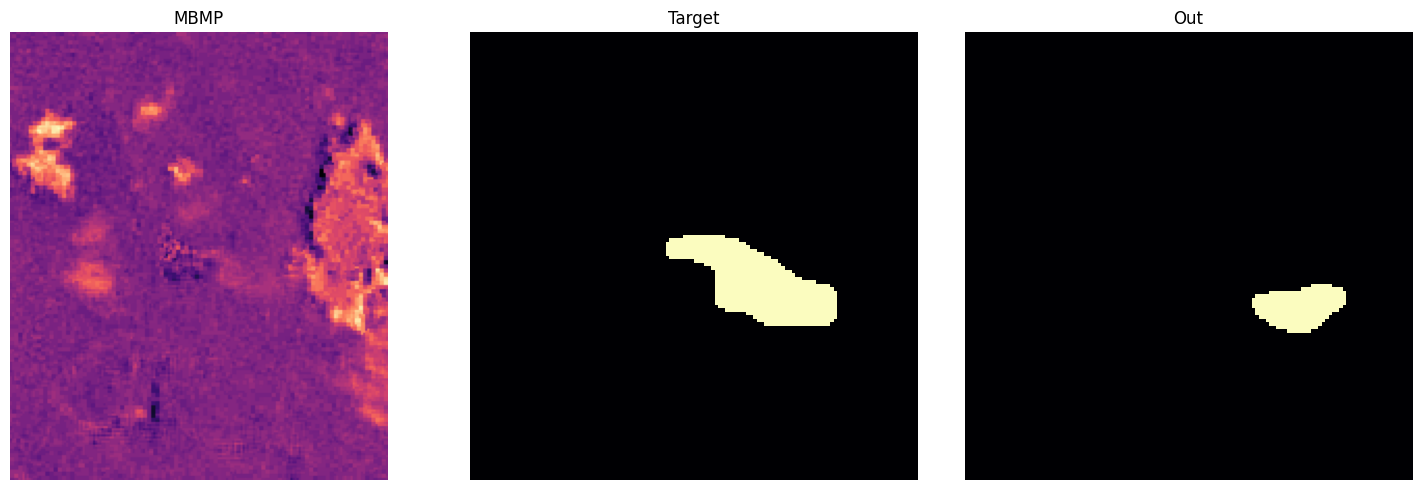

neg
1.6583747899529438e-07


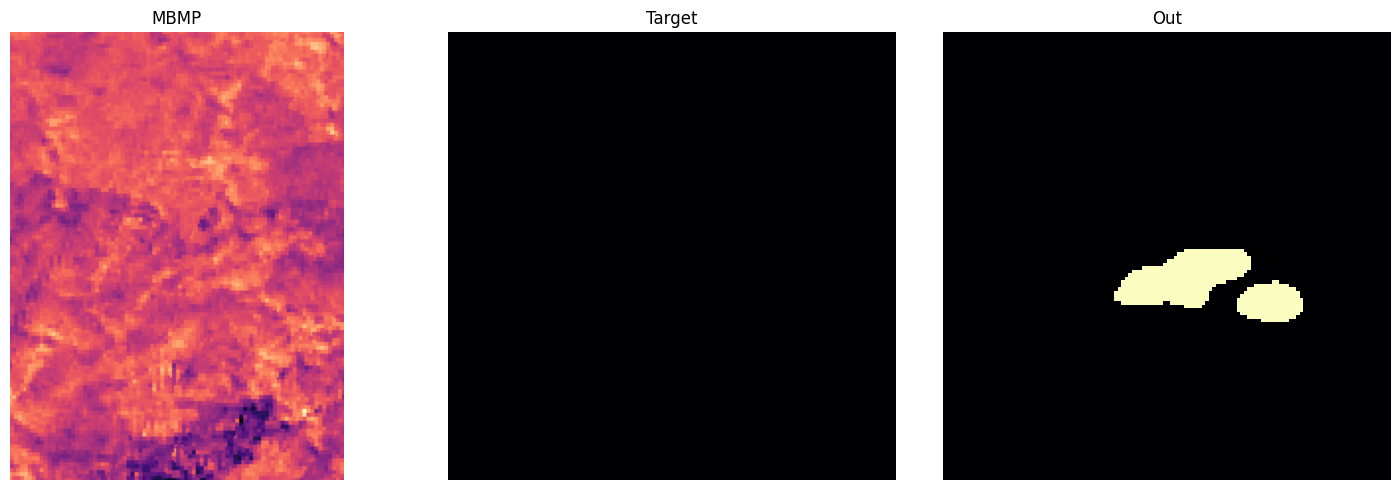

neg
3.154574122540775e-07


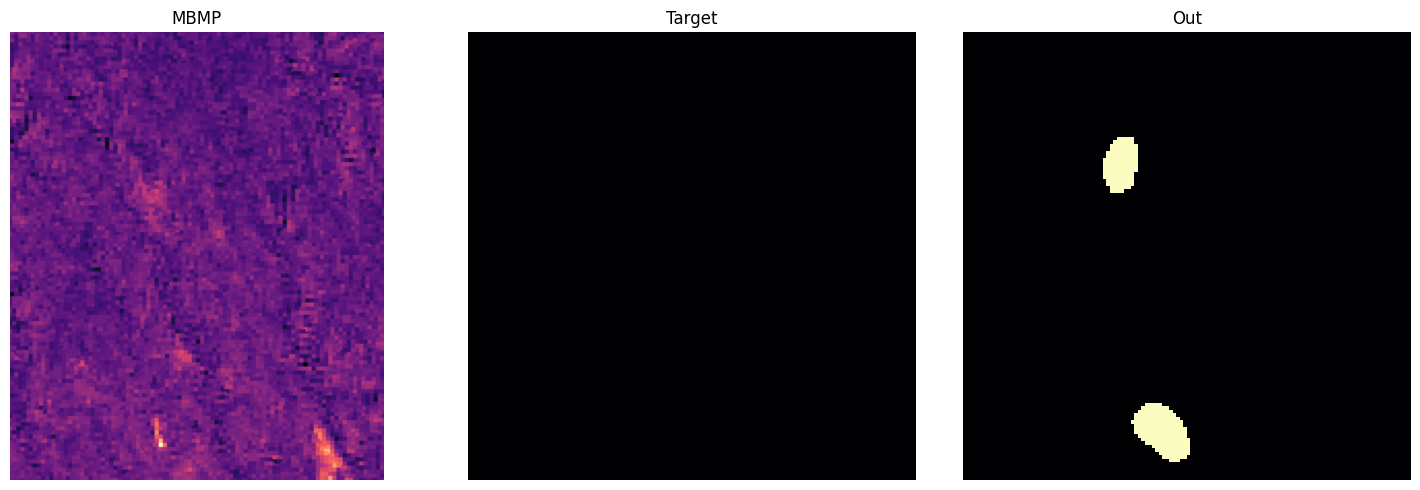

pos
19.24050653356834


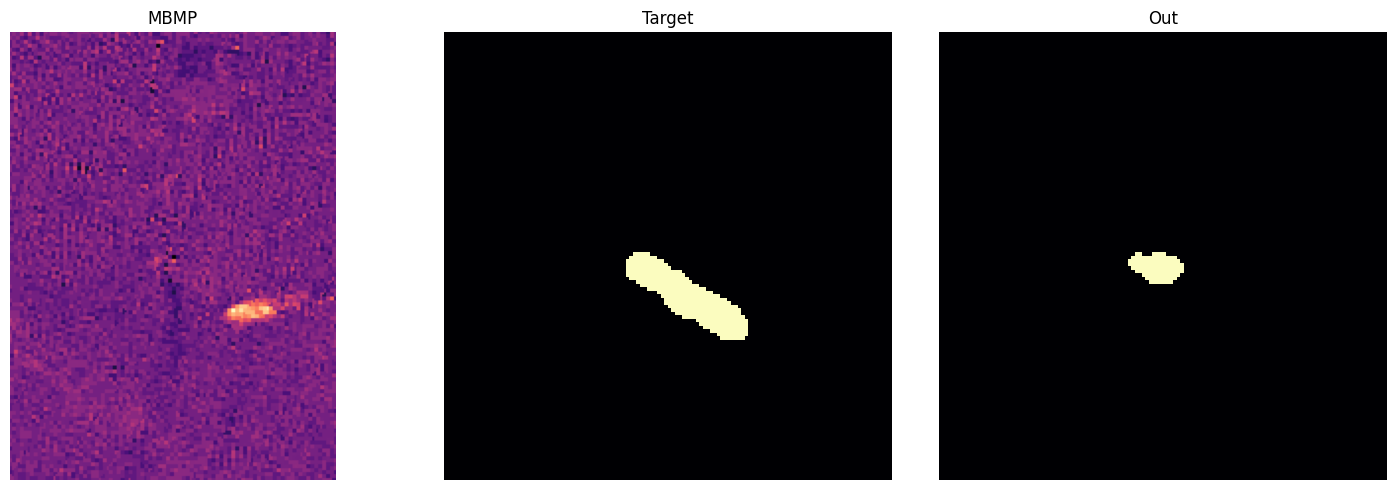

neg
100.0


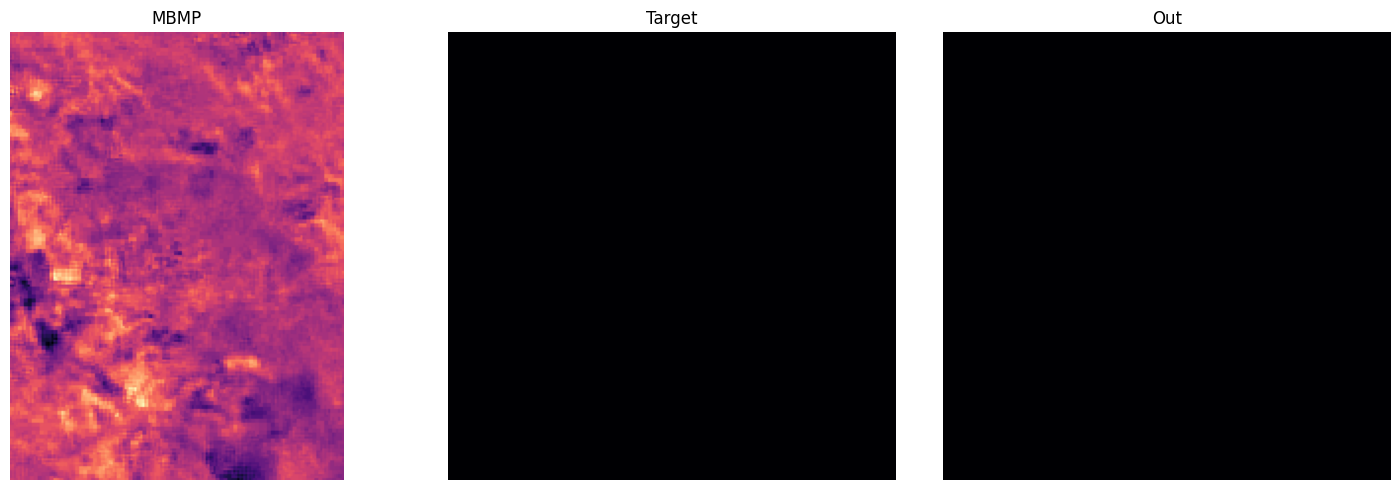

neg
100.0


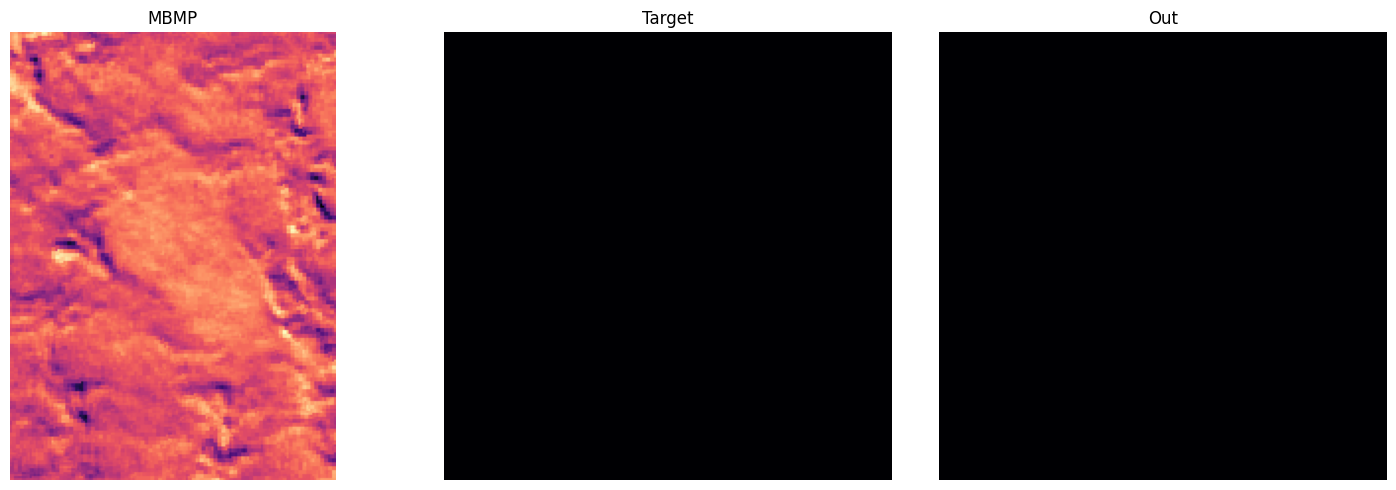

neg
100.0


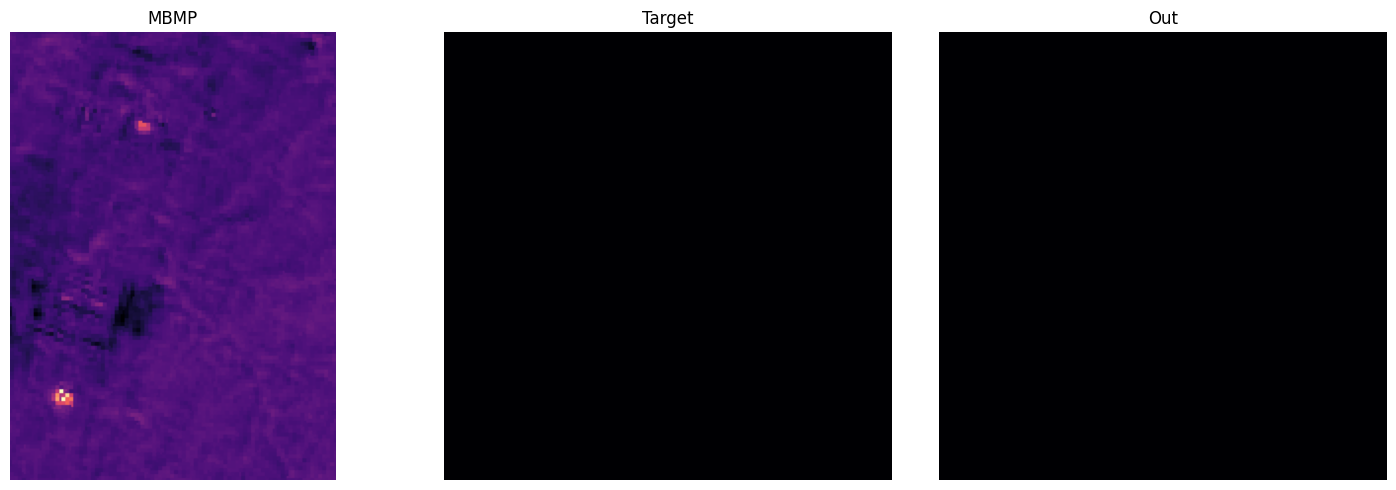

pos
62.61609910014233


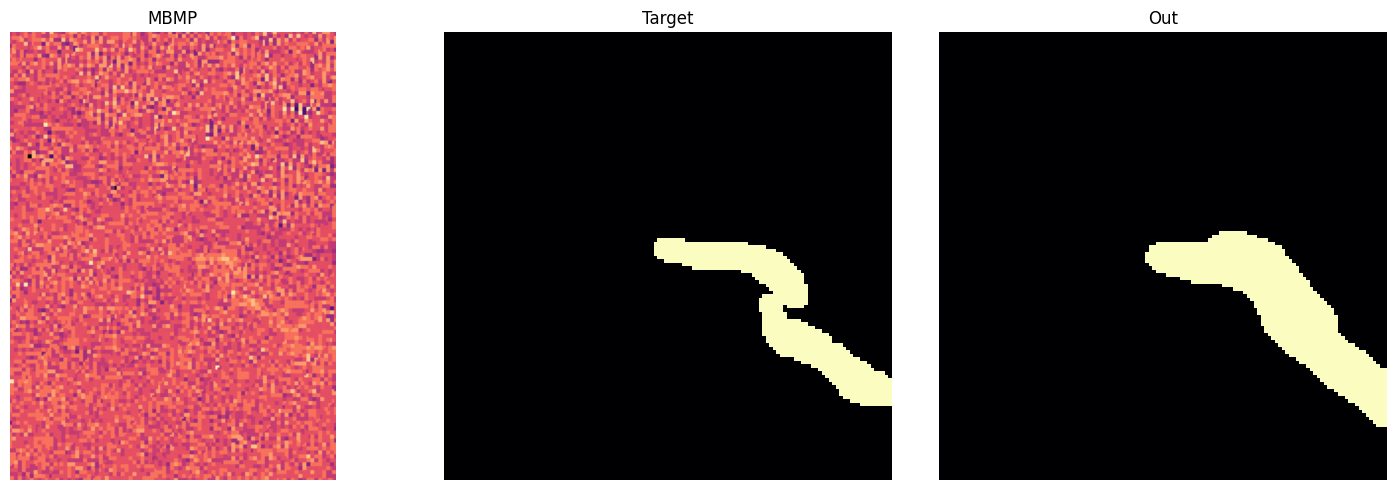

pos
13.75387806230209


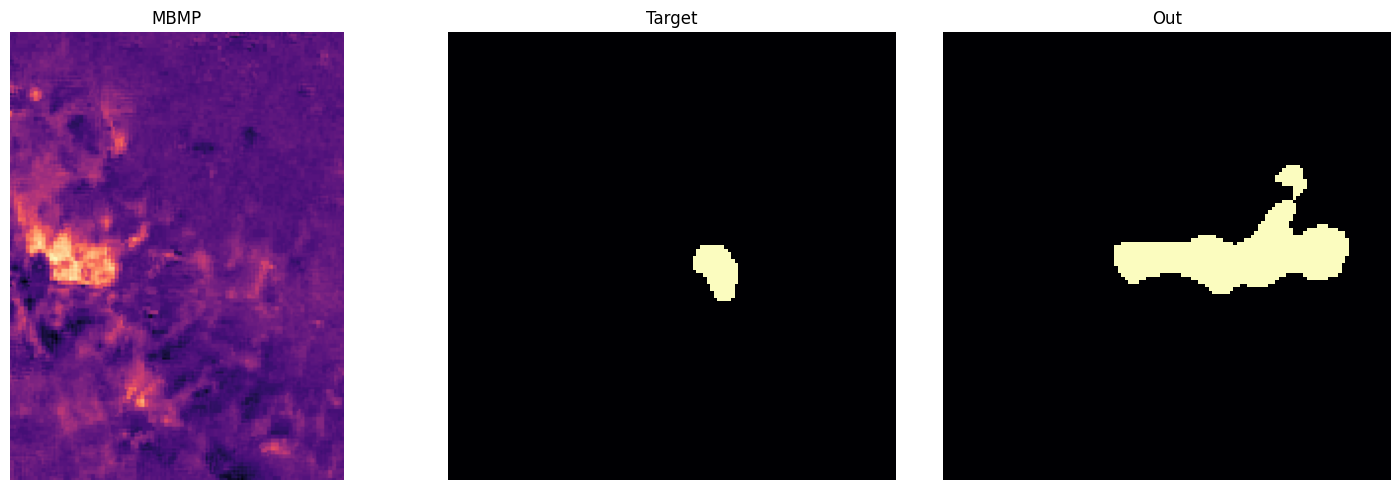

neg
100.0


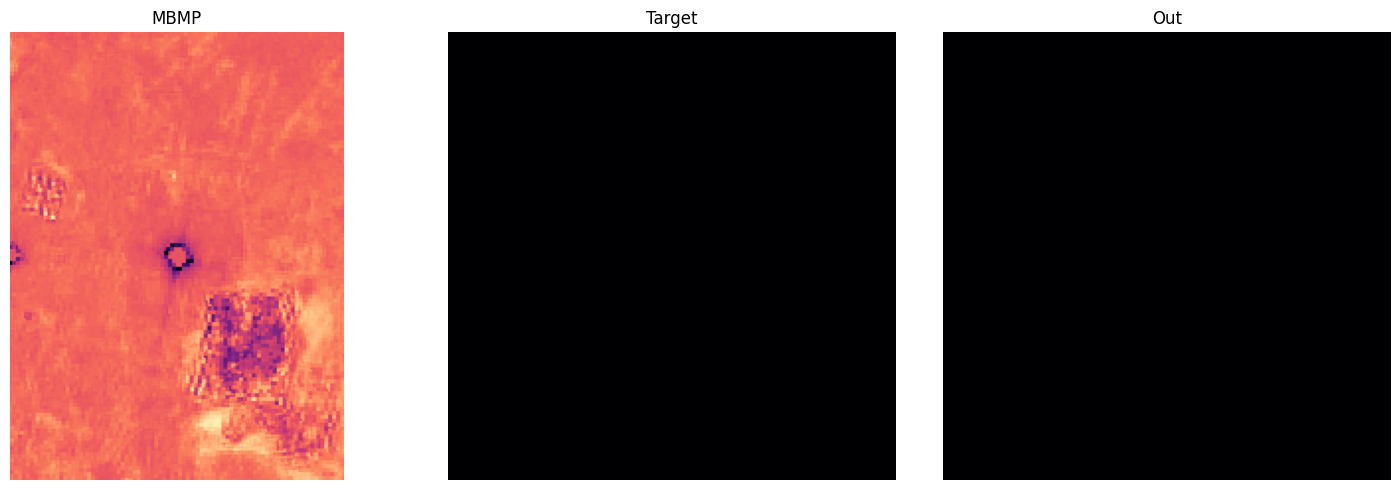

In [101]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==10): break
